# GHG emissions of Czechia in a given year

This notebooks details the data preparation and plotting of pie chart showing the greenhouse gas emissions in Czechia.

In [1]:
from datetime import date
import os
import sys

import pandas as pd

# Add the root dir to the path, so we can load the module.
sys.path.append(os.path.abspath("../../../"))

from data_analysis.emissions_pie_chart import *
from data_analysis.illustrator_strings import *
from data_analysis.texts_emissions import *
from data_analysis.allowances_utils import get_allowances_data
from data_analysis.eurostat_crf_utils import get_eurostat_crf_data_for_geo
from data_analysis.eurostat_geo import Geo
from data_analysis.eurostat_population_utils import get_eurostat_population_data_for_geo

### 1. The structure of the pie charts is defined (using CRF codes and EUA permit codes).

In [2]:
GEO = Geo.CZ
YEAR = 2021
TOTAL_EMISSION = 'TOTX4_MEMONIA'

definition = [
    {'id': 'electricity-heat',
     'label': 'Výroba elektřiny a tepla',
     'codes': ['CRF1A1A'],
     'color': '#ff4245',
     'breakdown': [
         {'id': 'CHP',
          'label': 'Teplárny',
          'color': '#d70205',
          'remainder': True},
         {'id': 'pocerady',
          'label': 'Elektrárna Počerady',
          'color': '#c22628',
          'codes': ['CZ-0204-05'],
          'allowances': True},
         {'id': 'ledvice',
          'label': 'Elektrárna Ledvice',
          'color': '#c22628',
          'codes': ['CZ-0201-05'],
          'allowances': True},
         {'id': 'prunerov',
          'label': 'Elektrárna Prunéřov',
          'color': '#c23d3f',
          'codes': ['CZ-0206-05', 'CZ-0207-05'],
          'allowances': True},
         {'id': 'tusimice',
          'label': 'Elektrárna Tušimice',
          'color': '#e11114',
          'codes': ['CZ-0209-05'],
          'allowances': True},
         {'id': 'chvaletice',
          'label': 'Elektrárna Chvaletice',
          'color': '#f01e23',
          'codes': ['CZ-0200-05'],
          'allowances': True},
         {'id': 'other-powerplants',
          'label': 'Ostatní elektrárny',
          'color': '#ff6e70',
          'codes': [
              'CZ-0092-05', 'CZ-0202-05', 'CZ-0203-05', # Elektrárna Mělník
              'CZ-0197-05',  # Teplárna a elektrárna Vřesová
              'CZ-0148-05', 'CZ-0417-06',  # Elektrárna Kladno
              'CZ-0080-05',  # Elektrárna Opatovice
              'CZ-0198-05',  # Elektrárna Dětmarovice
              'CZ-0208-05',  # Elektrárna Tisová
              'CZ-0317-05',  # Elektrárna Třebovice
              'CZ-0205-05',  # Elektrárna Poříčí
          ],
          'allowances': True}
     ]},
    {'id': 'industry',
     'label': 'Průmysl',
     'codes': ['CRF2', 'CRF1A2', 'CRF1A1B', 'CRF1A1C', 'CRF1B'],
     'color': '#7363bd',
     'breakdown': [
         {'id': 'metal',
          'label': 'Ocel a jiné kovy',
          'color': '#6e3394',
          'codes': ['CRF1A2A', 'CRF1A2B', 'CRF2C']},
         {'id': 'mineral',
          'label': 'Cement a jiné minerály',
          'color': '#7a45a1',
          'codes': ['CRF1A2F', 'CRF2A']},
         {'id': 'fuels',
          'label': 'Těžba, zpracování a transport paliv',
          'color': '#7a45a1',
          'codes': ['CRF1A1C', 'CRF1A1B', 'CRF1A3E', 'CRF1B']},
         {'id': 'other',
          'label': '',
          'color': '#ffffff00',
          'remainder': True},
     ]},
    {'id': 'transport',
     'label': 'Doprava (včetně letecké)',
     'codes': ['CRF1A3A', 'CRF1A3B', 'CRF1A3C', 'CRF1A3D', 'CRF1D1A'],
     'color': '#a10014',
     'breakdown': [
         {'id': 'cars',
          'label': 'Osobní automobilová doprava',
          'color': '#73000c',
          'codes': ['CRF1A3B1']},
         {'id': 'trucks-buses',
          'label': 'Nákladní a autobusová doprava',
          'color': '#8f0a19',
          'codes': ['CRF1A3B2', 'CRF1A3B3']},
         {'id': 'airplanes',
          'label': 'Letecká doprava',
          'color': '#94545c',
          'codes': ['CRF1D1A', 'CRF1A3A']},
         {'id': 'other',
          'label': '',
          'color': '#ffffff00',
          'remainder': True}
     ]},
    {'id': 'buildings',
     'label': 'Budovy',
     'codes': ['CRF1A4A', 'CRF1A4B'],
     'color': '#00007f'},
    {'id': 'agriculture',
     'label': 'Zemědělství',
     'codes': ['CRF1A4C', 'CRF3'],
     'color': '#1ecfbd'},
    {'id': 'waste',
     'label': 'Odpadové hospodářství',
     'codes': ['CRF5'],
     'color': '#029485'},
    {'id': 'other',
     'label': 'Jiné',
     'color': '#f8c551',
     'remainder': True}
]


### 2. Emissions values (in megatons) are loaded for all CRF codes and EUA permit codes that appear in the definition.

In [3]:
df = get_eurostat_crf_data_for_geo(GEO, YEAR)
df


,value
src_crf,
CRF1,88.66203
CRF1A,86.04676
CRF1A1,41.05353
CRF1A1A,39.30932
CRF1A1B,0.47982
...,...
TOTX4_MEMONIA,119.41326
TOTX4_MEMONIT,119.41326
TOTXMEMO,127.39365


In [4]:
allowance_permit_codes = []
for wedge_def in definition:
    for sub_wedge in wedge_def.get('breakdown', []):
        allowance_permit_codes += sub_wedge['codes'] if 'allowances' in sub_wedge else []

df_eua = df_eua_filtered = pd.DataFrame()
if allowance_permit_codes:
    df_eua = get_allowances_data(
        YEAR, registry_code=GEO.value, main_activity_code=20, eua_path="../../../data/EUA/verified_emissions_2021_en.xlsx")
    df_eua_filtered = df_eua.loc[df_eua.index.isin(allowance_permit_codes),]
    df = pd.concat([df, df_eua_filtered])

print("Facilities on our list:")
df_eua_filtered

Facilities on our list:


,value,IDENTIFIER_IN_REG
PERMIT_IDENTIFIER,,
CZ-0204-05,4.419807,"Elektrárna Počerady, a.s."
CZ-0201-05,3.781199,ČEZ - Elektrárna Ledvice
CZ-0207-05,3.494895,ČEZ - Elektrárna Prunéřov 2
CZ-0209-05,3.399410,ČEZ - Elektrárna Tušimice 2
CZ-0200-05,3.398295,Elektrárna Chvaletice a.s.
CZ-0197-05,2.237283,Teplárna a PPC Vřesová
CZ-0148-05,1.744353,Teplárna Kladno s.r.o.
CZ-0080-05,1.691752,Elektrárny Opatovice - Elektrárna Opatovice
CZ-0092-05,1.563087,ENERGOTRANS - Elektrárna Mělník 1


In [5]:
print("Top facilities with main activity code 20 not in our list, check them carefully:")
df_eua.loc[~ df_eua.index.isin(allowance_permit_codes),].head(15)

Top facilities with main activity code 20 not in our list, check them carefully:


,value,IDENTIFIER_IN_REG
PERMIT_IDENTIFIER,,
CZ-0134-05,3.083425,Liberty Ostrava a.s.
CZ-0400-05,2.487570,UNIPETROL - Petrochemie
CZ-0444-10,2.040795,TAMEH Czech
CZ-0101-05,1.507125,ENERGETIKA TŘINEC
CZ-0478-12,0.969700,"ČEZ, a. s. – EPC2"
CZ-0160-05,0.838445,ORLEN UNIPETROL - Energoblok EJ
CZ-0190-05,0.826466,United Energy - Teplárna Komořany
CZ-0237-05,0.474569,ČEZ - Teplárna Trmice
CZ-0259-05,0.429603,TAMERO INVEST - Teplárna Kralupy


### 3. List of inner and outer wedges is generated and printed into a CSV file (for processing in Illustrator)

In [6]:
total_value = get_emissions_value(TOTAL_EMISSION, df)
inner_wedges = get_emissions_wedges(definition, total_value, df)
inner_dict = {wedge.id: wedge.value for wedge in inner_wedges}

outer_wedges = []
for wedge_def in definition:
    if 'breakdown' in wedge_def:
        parent_id = wedge_def['id']
        parent_value = inner_dict[parent_id]
        outer_wedges += get_emissions_wedges(
            wedge_def['breakdown'], parent_value, df, parent_id)

df_wedges = print_emissions_wedges_to_csv(inner_wedges + outer_wedges, f"output-{GEO.value}-wedges.csv")
df_wedges

,value,parent_id,label
id,,,
electricity-heat,39.309320,None,Výroba elektřiny a tepla
industry,33.425170,None,Průmysl
transport,19.268190,None,Doprava (včetně letecké)
buildings,11.616760,None,Budovy
agriculture,9.072220,None,Zemědělství
waste,5.702110,None,Odpadové hospodářství
other,1.019490,None,Jiné
electricity-heat_CHP,9.673528,electricity-heat,Teplárny
electricity-heat_pocerady,4.419807,electricity-heat,Elektrárna Počerady


### 4. Strings (with occasional data) are generated for Illustrator.

In [7]:
population = get_eurostat_population_data_for_geo(GEO, YEAR)
emissions_per_person = total_value * 1_000_000 / population

strings: dict[str, str] = {
  "country-name-l": "v ČR",
  "country-name-g": "České republiky",
  "year": YEAR,
  "total-weight": czech_float(total_value, 2),
  "total-per-person": czech_float(emissions_per_person, 2),
  "lulucf-emissions": czech_float(get_emissions_value("CRF4", df), 2),
  "data-source": "Evropská agentura pro životní prostředí",
  "version": date.today().strftime("%Y-%m-%d"),
  "slug": "emise-cr",
}
df_strings = print_illustrator_strings_to_csv(strings, f"output-{GEO.value}-strings.csv")
df_strings

,value
id,
country-name-l,v ČR
country-name-g,České republiky
year,2021
total-weight,"119,41"
total-per-person,"11,38"
lulucf-emissions,"8,36"
data-source,Evropská agentura pro životní prostředí
version,2023-09-22
slug,emise-cr


### 5. A nested pie chart is generated (as a rough version of the final plot)

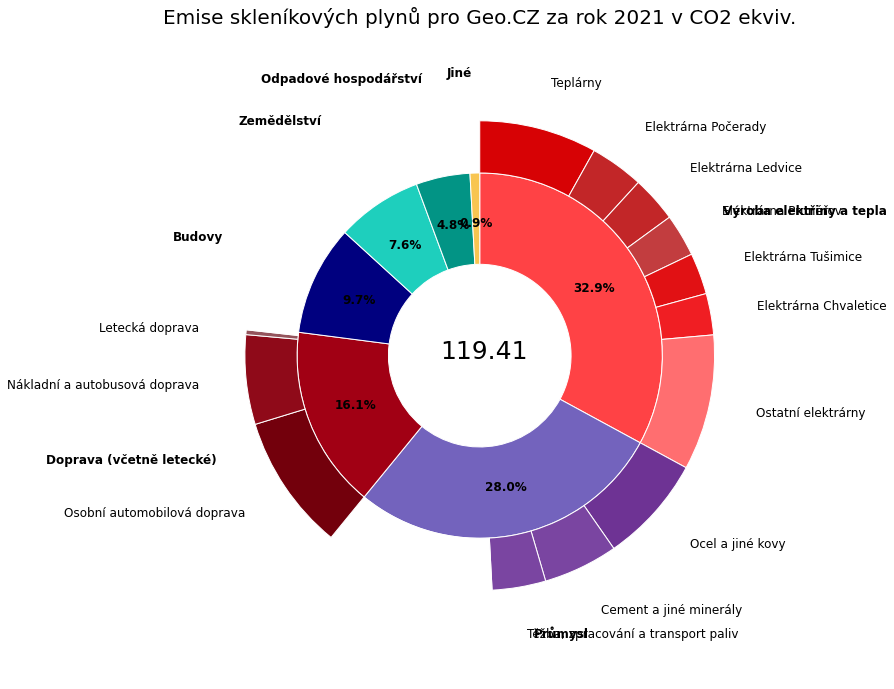

In [8]:
draw_emissions_pie_chart(GEO.value, YEAR, inner_wedges, outer_wedges, total_value)

### 6. Generate accompanying text for the web

First check the fact about top 5 coal plants vs. transport.

In [9]:
def _get(id: str) -> float:
    return df_wedges.loc[id, "value"]

total_5_largest = (_get("electricity-heat_pocerady") + _get("electricity-heat_ledvice") +
                   _get("electricity-heat_prunerov") + _get("electricity-heat_tusimice") +
                   _get("electricity-heat_chvaletice"))
road = _get("transport_cars") + _get("transport_trucks-buses")
print(f"Top 5 coal plants: {total_5_largest:.2f} Mt")
print(f"Road transport: {road:.2f} Mt")
print("Is it still similar? Consider rephrasing in get_sectoral_info(Sector.ELECTRICITY_HEAT, ...).")

Top 5 coal plants: 18.49 Mt
Road transport: 18.53 Mt
Is it still similar? Consider rephrasing in get_sectoral_info(Sector.ELECTRICITY_HEAT, ...).


In [10]:
accompanying_text = f'''---
layout:     infographic
title:      "Emise skleníkových plynů v ČR podle sektorů detailně"
slug:       "{strings["slug"]}"
redirect_from: ["/{strings["slug"]}", "/emise-cr-detail", "/infografiky/emise-cr-detail"]
published:  2019-07-20
weight:     50
tags-scopes: [ cr ]
tags-topics: [ emise ]
caption:    "Rozložení celkových emisí skleníkových plynů (v tunách CO<sub>2</sub> ekvivalentu) v ČR za rok {YEAR} v jednotlivých sektorech lidské činnosti. Roční objem emisí České republiky je {strings["total-weight"]} mil. tun (údaj z roku {YEAR}). V přepočtu na obyvatele to je {strings["total-per-person"]} t CO<sub>2</sub>eq/obyvatele."
dataset:    "emise-cr"
autogenerated: "WARNING! This text got autogenerated in faktaoklimatu/data-analysis on {strings["version"]}. Do not change here, fix it in the source notebook."
---

## Jak číst tento graf?

{get_gases_info()}

Roční objem emisí České republiky je {strings["total-weight"]} mil. tun CO<sub>2</sub>eq (údaj z roku {YEAR}). __V přepočtu na obyvatele to je {strings["total-per-person"]} t CO<sub>2</sub>eq/obyvatele.__

## Co znamenají jednotlivé sektory?

* {get_sectoral_info(Sector.ELECTRICITY_HEAT, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.INDUSTRY, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.TRANSPORT, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.BUILDINGS, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.AGRICULTURE, GEO, df_wedges, df, total_value, population)}
* {get_sectoral_info(Sector.WASTE, GEO, df_wedges, df, total_value, population)}

{get_lulucf_info(YEAR, strings)}

## Poznámky k datům o emisích
{get_methodology_info()}

{get_trade_and_flights_info(GEO)}
'''
print(accompanying_text)


---
layout:     infographic
title:      "Emise skleníkových plynů v ČR podle sektorů detailně"
slug:       "emise-cr"
redirect_from: ["/emise-cr", "/emise-cr-detail", "/infografiky/emise-cr-detail"]
published:  2019-07-20
weight:     50
tags-scopes: [ cr ]
tags-topics: [ emise ]
caption:    "Rozložení celkových emisí skleníkových plynů (v tunách CO<sub>2</sub> ekvivalentu) v ČR za rok 2021 v jednotlivých sektorech lidské činnosti. Roční objem emisí České republiky je 119,41 mil. tun (údaj z roku 2021). V přepočtu na obyvatele to je 11,38 t CO<sub>2</sub>eq/obyvatele."
dataset:    "emise-cr"
---

## Jak číst tento graf?

Všechny hodnoty v grafu jsou <glossary id="antropogennisklenikoveplyny">antropogenní emise</glossary> skleníkových plynů CO<sub>2</sub>, N<sub>2</sub>O, CH<sub>4</sub>, HFC, PFC, SF<sub>6</sub>, NF<sub>3</sub> vyjádřené jako <glossary id="co2eq">CO<sub>2</sub>eq</glossary>. Jednotka CO<sub>2</sub> ekvivalent zohledňuje dlouhodobý efekt skleníkových plynů v atmosféře a p